# Covid-19 Forecasting

Fazer uma previsão do número de pessoas infetadas e de fatalidades nos diversos países e identificar os fatores relevantes para esta previsão.

Em primeiro lugar, enriquecer o dataset com informações relevantes de cada país, como por exemplo informações demográficas e se possível sanitárias, e selecionar os atributos relevantes. Posteriormente utilizar regressão linear para a previsão e possivelmente incluir um modelo comportamental de epidemias para melhor ilustrar o problema e ainda otimização de parâmetros.

Em segundo lugar, ponderar outras técnicas de aprendizagem máquina tradicionais através de testes.

Por último, recorrer à utilização de RNN para comparar resultados com o primeiro modelo e tirar conclusões.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pycountry_convert as pc

In [2]:
kaggle_data_path = "../input/"
local_data_path = "data/"

train_dataset = pd.read_csv(local_data_path + "covid19-global-forecasting-week-4/train.csv")

In [3]:
def parse_data_by_continent(df_continent, csv, date, column):
    df = pd.read_csv(csv)
    n_rows = df.shape[0]
    
    for i in range(n_rows):
        country_name = df.at[i, "Country/Region"]
        if "(" in country_name:
            country_name = country_name.split()[0]
            #country_name = country_name[:-1]
        elif "Cote" in country_name:
            country_name = "Côte d'Ivoire"
        elif "Korea" in country_name:
            country_name = "Korea, Republic of"
        elif "Taiwan" in country_name:
            country_name = "Taiwan"
        elif "US" in country_name:
            country_name = "USA"
        
        try:
            country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)

            if continent_name == "EU":
                index = 0
            elif continent_name == "NA":
                index = 1
            elif continent_name == "SA":
                index = 2
            elif continent_name == "AS":
                index = 3
            elif continent_name == "AF":
                index = 4
            elif continent_name == "OC":
                index = 5

            df_continent.at[index, column] += df.at[i, date]
        except:
            pass

In [4]:
def data_by_continent(date, confirmed_csv, death_csv, recovered_csv, population_csv):
    data = {'Continent': ['Europe', 'North America', 'South America', 'Asia', 'Africa', 'Oceania'],
        'Population': [0, 0, 0, 0, 0, 0],
        'Confirmed': [0, 0, 0, 0, 0, 0],
        'Death': [0, 0, 0, 0, 0, 0],
        'Recovered': [0, 0, 0, 0, 0, 0]}

    df_continent = pd.DataFrame(data)
    
    parse_data_by_continent(df_continent, confirmed_csv, date, "Confirmed")
    parse_data_by_continent(df_continent, death_csv, date, "Death")
    parse_data_by_continent(df_continent, recovered_csv, date, "Recovered")
    
    df = pd.read_csv(population_csv)
    n_rows = df.shape[0]
    
    for i in range(n_rows):
        country_name = df.at[i, "Country (or dependent territory)"]
        if "(" in country_name:
            country_name = country_name.split('(')[0]
            country_name = country_name[:-1]
        
        try:
            country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)

            if continent_name == "EU":
                index = 0
            elif continent_name == "NA":
                index = 1
            elif continent_name == "SA":
                index = 2
            elif continent_name == "AS":
                index = 3
            elif continent_name == "AF":
                index = 4
            elif continent_name == "OC":
                index = 5

            df_continent.at[index, "Population"] += int(df.at[i, "Population"].replace(',', ''))
        except:
            pass

    return df_continent

In [5]:
cssegi_sand_data = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_global = cssegi_sand_data + "time_series_covid19_confirmed_global.csv"
death_global = cssegi_sand_data + "time_series_covid19_deaths_global.csv"
recovered_global = cssegi_sand_data + "time_series_covid19_recovered_global.csv"
population_global = local_data_path + "countries-dataset-2020/Pupulation density by countries.csv"

covid_by_continent = data_by_continent("5/1/20", confirmed_global, death_global, recovered_global, population_global)
covid_by_continent

,Continent,Population,Confirmed,Death,Recovered
0,Europe,745100622,1369704,137151,488606
1,North America,586466837,1199621,71178,202821
2,South America,421571654,190180,9485,63804
3,Asia,4557160159,533341,18955,275703
4,Africa,1278061183,40570,1692,13385
5,Oceania,42901670,8289,113,7050


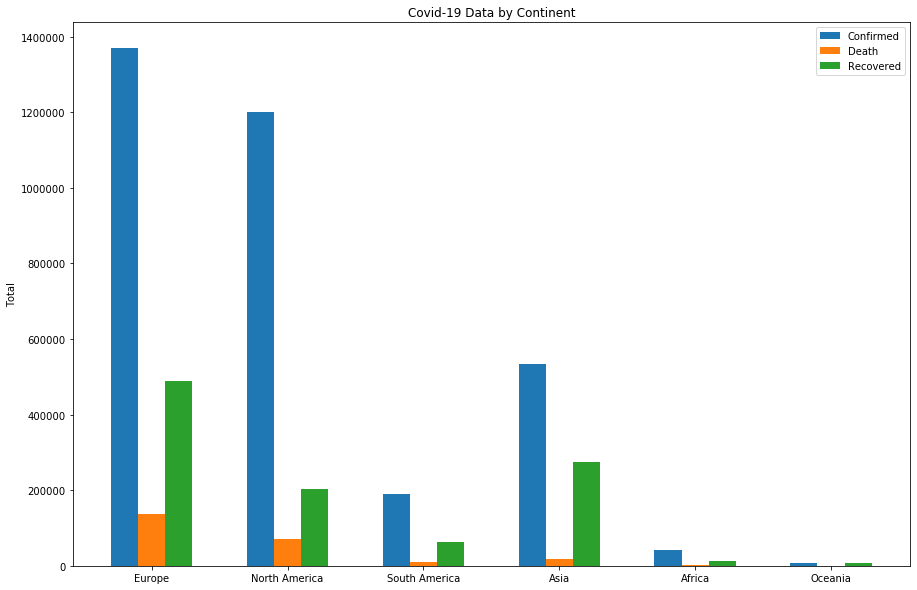

In [6]:
labels = covid_by_continent["Continent"]
confirmed = covid_by_continent["Confirmed"]
death = covid_by_continent["Death"]
recovered = covid_by_continent["Recovered"]
population = covid_by_continent["Population"]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x,           confirmed, width, label='Confirmed', align='center')
ax.bar(x + width,   death,     width, label='Death',     align='center')
ax.bar(x + width*2, recovered, width, label='Recovered', align='center')

ax.set_ylabel('Total')
ax.set_title('Covid-19 Data by Continent')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [7]:
population_dataset = pd.read_csv(local_data_path + "countries-dataset-2020/Pupulation density by countries.csv")

data_updated = train_dataset.loc[train_dataset['Date'] == '2020-05-01']

choosen_countries = {
    'Australia':     0,
    'Canada':        1,
    'Norway':        2,
    'South Korea':   3,
    'Japan':         4,
    'United States': 5,
    'Brazil':        6,
    'Sweden':        7,
    'Portugal':      8,
}

n = len(choosen_countries)

df = pd.DataFrame({
    'Country': list(choosen_countries.keys()),
    'ConfirmedCases': [0] * n,
    'Percentage of Infected': [0] * n
})

for country, index in choosen_countries.items():
    population_row = population_dataset.loc[population_dataset['Country (or dependent territory)'] == country]
    
    df.at[index, 'Population'] = population_row['Population'].iloc[0].replace(',', '')
    
    if country == "South Korea":
        country = "Korea, South"
    elif country == "United States":
        country = "US"
        
    covid_rows = data_updated.loc[data_updated['Country_Region'] == country]
    total_cofirmed = 0
    
    for _, row in covid_rows.iterrows():
        total_cofirmed += row['ConfirmedCases']
    df.at[index, 'ConfirmedCases'] = total_cofirmed
        
df

,Country,ConfirmedCases,Percentage of Infected,Population
0,Australia,6778,0,25649909
1,Canada,56329,0,37961548
2,Norway,7783,0,5367580
3,South Korea,10780,0,51780579
4,Japan,14305,0,126010000
5,United States,1103295,0,329470935
6,Brazil,92202,0,211270518
7,Sweden,21520,0,10365705
8,Portugal,25351,0,10276617


## **Exploração inicial dos dados**

In [ ]:
train_dataset.head()

O dataset inicial contém apenas o número de casos confirmados e as fatalidades por país e em alguns casos por província desse país, como é o caso da China. Para melhor entender a magnitude dos dados recolhidos vamos verificar a evolução dos casos confirmados e das fatalidades desde o início da propagação do vírus e a nível global. 

In [ ]:
total_confirmed = train_dataset.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities = train_dataset.groupby(['Date']).agg({'Fatalities':['sum']})
total_confirmed.join(total_fatalities).plot()

É possível verificar que o crescimento dos casos confirmados é exponencial, estando perto dos 2.7 milhões, porém e felizmente, o número de fatalidades revela um comportamento bastante mais plano. O gráfico parece ter pouca suavidade no início da propagação, o que deverá estar relacionado com o facto de ter tido apenas um foco inicial, sendo ele a China e que a avaliação de doentes infetados tenha sido mais drástica a partir de um certo ponto.

Após esta análise inicial é possível verificar que a epidemia comporta-se de maneira diferente em muitos países. Obviamente que os números nunca poderiam ser iguais, visto que ela não começou ao mesmo tempo em todos os países, mas também não são iguais devido a um grande número de fatores, entre eles, está a densidade populacional, a idade da população, os níveis sanitários, as medidas de contenção implementadas, testes realizados e até o encobrimento de dados. Como exemplo podemos analisar os seguinte gráficos.

In [ ]:
china_data = train_dataset[train_dataset['Country_Region'] == 'China']
total_confirmed_china = china_data.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities_china = china_data.groupby(['Date']).agg({'Fatalities':['sum']})


nigeria_data = train_dataset[train_dataset['Country_Region'] == 'Nigeria']
total_confirmed_nigeria = nigeria_data.groupby(['Date']).agg({'ConfirmedCases':['sum']})
total_fatalities_nigeria= nigeria_data.groupby(['Date']).agg({'Fatalities':['sum']})


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.set_title("China analysis")
ax2.set_title("Nigeria analysis")
total_confirmed_china.join(total_fatalities_china).plot(ax=ax1)
total_confirmed_nigeria.join(total_fatalities_nigeria).plot(ax=ax2)


Nos dois plots anteriores podemos ver dois casos que se revelam anómalos.
Em primeiro lugar, podemos olhar para a Nigeria que é um dos países com maior população do mundo e, apesar de o vírus já ter chegado a este país, ainda foram registados muitos poucos casos. Creemos que isto terá a ver com a infelicidade das inúmeras dificuldades sociais e económicas deste país o que torna complicado o acto de diagnosticar/testar e até mesmo registar os casos relacionados com o vírus.

Em segundo lugar, nada mais do que a China que apesar de ter sido o epicentro de tudo e de não estar preparada apenas reporta até à data um máximo de 4512 mortes, como podemos verificar pela tabela seguinte, sendo que o número de casos confirmados ficou bastante estagnado. Com isto, não queremos dizer que a China está a mentir nos seus números, mas é de facto um caso que revela um comportamento diferente do vírus, talvez devido às duras medidas implementadas na província de Wuhan, porém elas foram implementadas um pouco tarde.

In [ ]:
china_data.describe()

Posto isto, não faria muito sentido estar a prever a evolução desta epidemia globalmente, por isso vamo-nos focar num país que tem sido elogiado pelo combate ao COVID-19 e cujas informações apresentadas parecem ser credíveis e que é Portugal. Por sorte, encontramos um dataset mais detalhado sobre Portugal e com informações fornecidas pela DGS e que também contém as informações fornecidas pelo anterior.

In [ ]:
train_dataset = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
train_dataset

O dataset não vem ordenado por dia por isso é necessário fazer essa ordenação, para além disso para já vamos converter os NaN para 0.

In [ ]:
train_dataset = train_dataset.sort_values(by=['id'])
train_dataset = train_dataset.fillna(0)

Este dataset tem muitos detalhes sobre os números do covid-19 em Portugal, chegando a ter o número de casos confirmados e obitos dividido por idades e sexo. De seguida mostra-mos apenas, como exemplo, estas divisões para os casos confirmados

In [ ]:
train_dataset[train_dataset.columns[10:19]].head()

In [ ]:
train_dataset[train_dataset.columns[19:28]].head()

É importante logo à partida reduzir o número de features relevantes. Primeiro é fácil de constatar que o número de casos confirmados terá impacto direto, mais à frente, no número de mortes, isto porque este número é um subconjunto dos confirmados. Com isto, vamos agregar os dados de casos confirmados e de obitos por faixas etárias: Jovens (0-29), Idade Média (30-59) e Terceira Idade (60-sup), não fazendo qualquer distinção entre géneros. Pretendemos, assim, isolar a faixa determinante para o número de fatalidades no pais.

In [ ]:
confirmados_jovens = train_dataset['confirmados_masculino_0_9'] + train_dataset['confirmados_masculino_10_19'] + train_dataset['confirmados_masculino_20_29'] 
+ train_dataset['confirmados_feminino_0_9'] + train_dataset['confirmados_feminino_10_19'] + train_dataset['confirmados_feminino_20_29'] 

fatalidades_jovens = train_dataset['obitos_masculino_0_9'] + train_dataset['obitos_masculino_10_19'] + train_dataset['obitos_masculino_20_29'] 
+ train_dataset['obitos_feminino_0_9'] + train_dataset['obitos_feminino_10_19'] + train_dataset['obitos_feminino_20_29'] 

confirmados_meia_idade = train_dataset['confirmados_masculino_30_39'] + train_dataset['confirmados_masculino_40_49'] + train_dataset['confirmados_masculino_50_59'] 
+ train_dataset['confirmados_feminino_30_39'] + train_dataset['confirmados_feminino_40_49'] + train_dataset['confirmados_feminino_50_59'] 

fatalidades_meia_idade = train_dataset['obitos_masculino_30_39'] + train_dataset['obitos_masculino_40_49'] + train_dataset['obitos_masculino_50_59']
+ train_dataset['obitos_feminino_30_39'] + train_dataset['obitos_feminino_40_49'] + train_dataset['obitos_feminino_50_59'] 

confirmados_terceira_idade = train_dataset['confirmados_masculino_60_69'] + train_dataset['confirmados_masculino_70_79'] + train_dataset['confirmados_masculino_80_sup'] 
+ train_dataset['confirmados_feminino_60_69'] + train_dataset['confirmados_feminino_70_79'] + train_dataset['confirmados_feminino_80_sup'] 

fatalidades_terceira_idade = train_dataset['obitos_masculino_60_69'] + train_dataset['obitos_masculino_70_79'] + train_dataset['obitos_masculino_80_sup'] 
+ train_dataset['obitos_feminino_60_69'] + train_dataset['obitos_feminino_70_79'] + train_dataset['obitos_feminino_80_sup'] 

pd.concat([confirmados_jovens,fatalidades_jovens], axis=1, keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(20,5), title='Jovens')
pd.concat([confirmados_meia_idade,fatalidades_meia_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(20,5), title='Meia Idade')
pd.concat([confirmados_terceira_idade,fatalidades_terceira_idade], axis=1,  keys=['Confirmados', 'Fatalidades']).tail(20).plot(kind='bar', figsize=(20,5), title='Terceira Idade')

Posto isto, conseguimos verificar que pelas informações do dataset apenas a população da terceira idade é que tem vindo a apresentar fatalidades, por isso vamos retirar do dataset as colunas de confirmados referentes às outras faixas etárias, porque não terão impacto na previsão dos casos de fatalidades. No caso dos óbitos iremos retirar as colunas todas, pois elas são apenas parte da soma que já temos e que queremos prever, sendo que apenas serviram para chegar à conclusão anterior. Iremos então manter os confirmados_terceira_idade no dataset.

Iremos aproveitar, também, para retirar já duas colunas desnecessárias. Primeiro o 'url' que apenas contém a fonte dos dados (relatório DGS) e depois a data do relatório, isto porque iremos referirmo-nos aos casos apenas como uma sequencia a partir do dia 1 (início dos dados) e até ao dia do último dado.

O dataset também inclui o total de recuperados, mas eles irão ser retirados, porque não serão o nosso foco neste trabalho. A coluna nao_confirmados irá ser retirada, pois não apresenta informação útil, assumindo que estes casos são os que foram testados e acusaram negativo (é esta a nossa interpretação). Os casos 'importados' também, claramente, não revelam qualquer importância para a previção e serão removidos

In [ ]:
columns1 = [x for x in range(10, 28)]
columns2 = [x for x in range(37, 55)]
train_dataset = train_dataset.drop(train_dataset.columns[columns1 + columns2], axis=1)
train_dataset = train_dataset.drop(['url', 'nao_confirmados', 'recuperados', 'data_relatorio', 'importados'], axis=1)
train_dataset.insert(2,'confirmados_terceira_idade',confirmados_terceira_idade)

In [ ]:
train_dataset.head()

De seguida vamos analisar as colunas dos sintomas. 

In [ ]:
sintomas = []
sintomas.append(train_dataset['sintoma_febre'].sum())
sintomas.append(train_dataset['sintoma_tosse'].sum())
sintomas.append(train_dataset['sintoma_respiratoria'].sum())
sintomas.append(train_dataset['sintoma_dores'].sum())
sintomas.append(train_dataset['sintoma_cefaleia'].sum())
sintomas.append(train_dataset['sintoma_fraqueza'].sum())
plt.bar(['febre', 'tosse', 'dif_respiratoria', 'dores', 'fraqueza', 'cefaleia'], sintomas)

Claramente o maior sintoma é a tosse, porém os restantes também são bastante comuns, sendo o menos comum a dificuldade respiratória que, na nossa opinião, terá a ver com o facto de estes sintomas serem os sintomas apresentados numa fase inicial da doença e quando é feito o diagnóstico, sendo que a dificuldade respiratória será algo mais característico de fases mais avançadas da doença. 


//-----Ver Melhor-----\\

Para a análise que vamos fazer os sintomas seriam interessantes se os conseguissemos relacionar diretamente com o número de obitos, para ver se pessoas que inicialmente apresentam determinados sintomas morrem/sobrevivem mais, mas isto com os dados presentes é algo praticamente impossível, porque, em primeiro lugar, os sintomas apresentados no dia X não tem impacto nos obitos do dia X, logo não existe correlação digna a ser tirada, a não ser que essa informação fosse fornecida, ou seja, número de obitos por sintoma. Em segundo lugar, para resolver o primeiro problema teriamos de tentar prever qual é que seria o periodo de sobrevivência genérico de alguém acabou por morrer de COVID-19, para depois relacionar os sintomas do dia X com os obitos do dia X+(periodo de sobrevivência) e como este tempo depende de inúmeros fatores não é algo que vamos conseguir fazer. Posto isto, os dados teriam de ter um mapeamente muito mais detalhado, relacionando obito com sintoma inicial, o que algo que não possuímos de momento.

//-----           -----\\

Vamos proceder então à sua remoção.

In [ ]:
columns = [x for x in range(9, 15)]
train_dataset = train_dataset.drop(train_dataset.columns[columns], axis=1)

In [ ]:
train_dataset.head()

Embora, como discutimos anteriormente, seja difícil com os dados que temos estimar, em média, quanto tempo uma pessoa que faleceu permaneceu viva desde o momento em que foi diagnosticada e mesmo conseguindo o intervalo seria grande, o mesmo não se aplica ao periodo de incubação que está definido entre 1 a 14 dias. Embora a comunidade científica não tenha certezas quanto a este tempo, podendo haver flutuações no máximo de tempo que pode demorar a demonstrar sintomas, de momento é uma das poucas informações consencuais que existem sobre o vírus. Posto isto, vamos tentar analisar o restante dataset de acordo com este dado.

Fora colunas básicas e já discutidas como 'confirmados', 'obitos' e 'confirmados_terceira_idade' ainda falta discutir sobre algumas colunas. Primeiro podemos abordar as colunas 'suspeitos', 'aguarda_resultado' e 'em_vigilancia', sendo que elas caem todas na mesma categoria que é a de serem um subconjunto dos casos confirmados. Embora muitos indivíduos destas categorias não estejam infetados, alguns deles podem, num futuro próximo, vir a fazer parte do grupo dos confirmados, por isso são colunas a ter em consideração. Em segundo lugar temos as colunas 'internados' e 'internados_uci' estando estas relacionadas com o número de obitos.

Para que isto tudo faça sentido temos de falar sobre o conceito de lags. Uma das dificuldades em prever os números desta pandemia é que observações registadas no dia X só terão impacto visível no dia X+N, podendo ser o N o periodo de incubação do vírus, ou o tempo que demora alguém contagiado a falecer. Por isso, temos de arranjar maneira de manter os valores antigos para os poder relacionar com os mais novos em relação aos anteriores. Para este efeito iremos utilizar os lags que são uma maneira de manter o valor anterior de uma coluna, introduzindo-o numa nova coluna, fazendo, basicamente, um 'shift' nos dados. 

Tendo o conceito de lag claro, vamos proceder a utilizar este cálculo para certas colunas. Vejamos então caso a caso.

Aguarda resultados. A receção de um resultado de um teste ao COVID-19 pode resultar num caso confirmado, sendo que o tempo desta receção poderá variar, consoante o congestionamento do serviço de análises. Iremos tomar pelo princípio de que não deverá demorar mais do que 2 dias, portanto esta coluna irá ser transformada em duas. A primeira tendo os valores da coluna em questão, mas com o 'shifts' de um dia e a segunda com um 'shift' de dois dias.